In [1]:
import os

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, LSTM, Conv1D, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pickle

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [2]:
input_data = pd.read_csv('time_series_covid19_confirmed_global.csv')
input_data = input_data[input_data['Country/Region'] == 'US']
input_data = input_data.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
input_data = input_data.transpose()

In [3]:
# Scaling data
scaler = StandardScaler()
scaler.fit(input_data[:3*len(input_data)//4]) # 0.75 because train_size is 75% of given data
copy = scaler.transform(input_data)

timestep = 1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)   
        
    return agg

train = series_to_supervised(copy).values
print(np.array(train).shape)

(201, 2)


In [4]:
X_train = []
y_train = []

for i in range(timestep, len(input_data)-1):
    X_train.append(train[i-timestep:i, :len(input_data.columns)])
    y_train.append(train[i-timestep, len(input_data.columns):])
    
X_train, y_train = np.array(X_train), np.array(y_train)

data_dump = X_train, y_train

with open("./data.pickle","wb+") as pickle_out:
    pickle.dump(data_dump, pickle_out)

with open("./scaler.pickle","wb+") as pickle_out:
    pickle.dump(scaler, pickle_out)

In [5]:
with open("./data.pickle", "rb") as f:
    X_train, y_train = pickle.load(f)

In [6]:
model = Sequential()
model.add(LSTM(512, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(256, activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll = False, use_bias = True, return_sequences = True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(X_train.shape[2]))

model.compile(loss = 'mae', optimizer = Adam(lr = 1e-3))

In [8]:
# Model checkpoint callback to save model with lowest validation loss
cp_callbacks = ModelCheckpoint(filepath = "./model.h5", monitor = "val_loss", mode = 'min', save_best_only = True, verbose = 1)

# Fit model
history = model.fit(X_train, y_train, epochs = 90, batch_size = 256, validation_split = 0.25, callbacks = [cp_callbacks])

Epoch 1/90
1/1 [==============================] - ETA: 0s - loss: 0.8759
Epoch 00001: val_loss improved from inf to 3.64293, saving model to ./model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.8759 - val_loss: 3.6429
Epoch 2/90
1/1 [==============================] - ETA: 0s - loss: 0.8452
Epoch 00002: val_loss improved from 3.64293 to 3.54523, saving model to ./model.h5
1/1 [==============================] - 0s 127ms/step - loss: 0.8452 - val_loss: 3.5452
Epoch 3/90
1/1 [==============================] - ETA: 0s - loss: 0.8038
Epoch 00003: val_loss improved from 3.54523 to 3.39404, saving model to ./model.h5
1/1 [==============================] - 0s 104ms/step - loss: 0.8038 - val_loss: 3.3940
Epoch 4/90
1/1 [==============================] - ETA: 0s - loss: 0.7489
Epoch 00004: val_loss improved from 3.39404 to 3.17630, saving model to ./model.h5
1/1 [==============================] - 0s 112ms/step - loss: 0.7489 - val_loss: 3.1763
Epoch 5/90
1/1 [=================

Epoch 38/90
1/1 [==============================] - ETA: 0s - loss: 0.0309
Epoch 00038: val_loss did not improve from 0.04046
1/1 [==============================] - 0s 33ms/step - loss: 0.0309 - val_loss: 0.2380
Epoch 39/90
1/1 [==============================] - ETA: 0s - loss: 0.0394
Epoch 00039: val_loss did not improve from 0.04046
1/1 [==============================] - 0s 31ms/step - loss: 0.0394 - val_loss: 0.1267
Epoch 40/90
1/1 [==============================] - ETA: 0s - loss: 0.0342
Epoch 00040: val_loss did not improve from 0.04046
1/1 [==============================] - 0s 40ms/step - loss: 0.0342 - val_loss: 0.0591
Epoch 41/90
1/1 [==============================] - ETA: 0s - loss: 0.0378
Epoch 00041: val_loss did not improve from 0.04046
1/1 [==============================] - 0s 33ms/step - loss: 0.0378 - val_loss: 0.1136
Epoch 42/90
1/1 [==============================] - ETA: 0s - loss: 0.0433
Epoch 00042: val_loss improved from 0.04046 to 0.01833, saving model to ./model.h5

Epoch 77/90
1/1 [==============================] - ETA: 0s - loss: 0.0220
Epoch 00077: val_loss did not improve from 0.01833
1/1 [==============================] - 0s 37ms/step - loss: 0.0220 - val_loss: 0.2999
Epoch 78/90
1/1 [==============================] - ETA: 0s - loss: 0.0230
Epoch 00078: val_loss did not improve from 0.01833
1/1 [==============================] - 0s 35ms/step - loss: 0.0230 - val_loss: 0.3429
Epoch 79/90
1/1 [==============================] - ETA: 0s - loss: 0.0197
Epoch 00079: val_loss did not improve from 0.01833
1/1 [==============================] - 0s 45ms/step - loss: 0.0197 - val_loss: 0.3733
Epoch 80/90
1/1 [==============================] - ETA: 0s - loss: 0.0223
Epoch 00080: val_loss did not improve from 0.01833
1/1 [==============================] - 0s 36ms/step - loss: 0.0223 - val_loss: 0.3038
Epoch 81/90
1/1 [==============================] - ETA: 0s - loss: 0.0169
Epoch 00081: val_loss did not improve from 0.01833
1/1 [==========================

In [9]:
model = tf.keras.models.load_model("./model.h5")

validation_target = y_train[3*len(X_train)//4:]
validation_predictions = []
error = []

# index of first validation input
i = 3*len(X_train)//4

while len(validation_predictions) < len(validation_target) - 1:
  p = model.predict(X_train[i].reshape(1, X_train.shape[1], X_train.shape[2]))[0] 
  i += 1
  error.append(mean_absolute_error(p,y_train[i]))

  # update the predictions list
  validation_predictions.append(p)

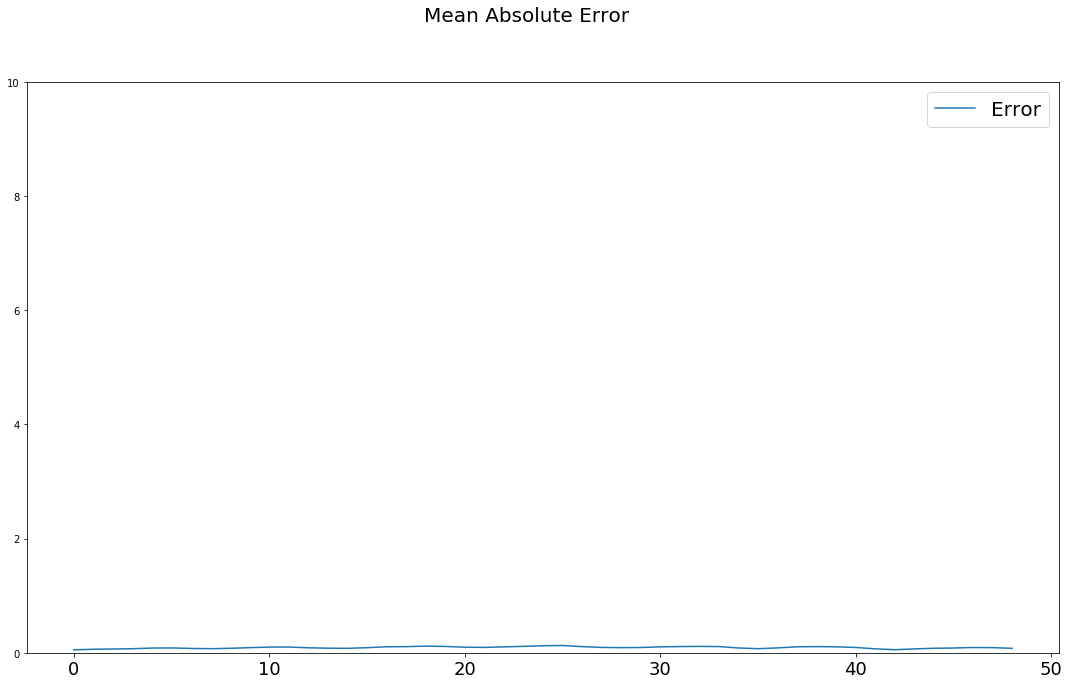

In [10]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Mean Absolute Error', size=20)
plt.plot(error, label='Error')
plt.xticks(fontsize=18)
plt.ylim(0, 10)
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
with open('./scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
    
for i in range(validation_target.shape[1]):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Fig "+str(i+1)+": Predicted and actual values ", size=30)
    plt.plot(scaler.inverse_transform(validation_target)[:, i], label='Actual')
    plt.plot(scaler.inverse_transform(np.array(validation_predictions))[:, i], '--', label='Predicted')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(prop={'size': 20})
    plt.show()